# Classification of Power Outage Causes


### Introduction
Whenever there is a power outage, one of the big questions is what caused it. Naturally we would like to know the cause of the power outage so we can improve our infustructure or prevent a similar outage from happening. What this model can't be used for, however, is identifying an outage's cause before it is repaired. Although this would be helpful, this can't be done since one of our main explanatory variables is the outage's duration.

This will be a classification problem since we are trying to classify the type of power outage. We will use a K-nearest neighbor classifier with the target variable being power outage. For the evaluation metric we will use the accuracy score (proportion of predictions being correct). Our goal should be to predict the outage cause correctly as often as possible, so naturally we would use the proportion of outages correctly predicted as our evaluation metric.

### Baseline Model
For the baseline model we will use 11 explanatory variables in all. There are two nominal explanatory variables: POSTAL.CODE and CLIMATE.REGION. The rest of the variables are quantitative: OUTAGE.DURATION, TOTAL.CUSTOMERS, MONTH, PC.REALGSP.STATE, UTIL.CONTRI, AREAPCT_URBAN, ANOMOLY.LEVEL, and TOTAL.SALES.

The baseline model has an accuracy rate of 0.5452. At first look this accuracy rate seems low. 46% of the time the model is incorrect? However, we have to assess the model relative to using nothing at all to see if it has any value. Considering the accuracy rate of randomly guessing is only 0.3368 our model presents a valuable improvement.

### Final Model
For the final model engineer three features. The first is a one-hot encoding of MONTH since it was being treated as quantitative in the baseline model, which doesn't make any sense. The next is a standardized version of ANOMOLY.LEVEL by CLIMATE.REGION. We would expect the anomoly level to vary by climate region, so standardizing it by each region should more accurately identify temperature anomolies. Finally, we see considerable skewness in outage duration. We should be able to get more accurate results if we apply a log transformation to this variable thereby applying less weight to the very high outage durations.

This time the same K-nearest neighbor classifier model is used except the number of neighbors is optimized. The optimal number of neighbors of 48 was found using grid search with 5 folds.

In addition, outage duration outliers are removed.

This model had an accuracy rate of about 0.67, meaning it improved upon the baseline model.

### Fairness Evaluation
Finally the model is evaluated for its fairness in prediction between high and low income states. We wouldn't want the model to predict outage cause with different accuracy for high and low income states. Since our response variable is not a binary variable we can't use a parity measure like precision. We will use accuracy rate as the parity measure since it is the most relevant to what we are trying to accomplish and links this fairness evaluation to how we evaluated the performance of the model in the prior portions of this study. A permutation test will be performed

From the results of the permutation test, there is not evidence to suggest that the model predicts unfairly between high and low income states.

# Code

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin



%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [5]:
#importing data and putting it into the correct format
data = pd.read_excel('outage.xlsx')

data = data.drop(index=[0,1,2,3,5], axis=0)
new_header = data.iloc[0]
data = data[1:]
data.columns = new_header
data = data.drop(labels='variables', axis=1)
data = data.reset_index()

### Baseline Model

In the baseline model I will attempt to classify the cause of power outages using just the base (non transformed) variables). All the variables selected, as listed in the following cell, seem like they would be the most closely related with the cause of the power outage. The data is cleaned before the model is made.

In [81]:
subset = data[['CAUSE.CATEGORY', 'OUTAGE.DURATION','POSTAL.CODE', 'TOTAL.CUSTOMERS', 'MONTH', 'PC.REALGSP.STATE', 'UTIL.CONTRI', 'AREAPCT_URBAN', 'ANOMALY.LEVEL', 'CLIMATE.REGION','TOTAL.SALES']]

In [82]:
subset

4,CAUSE.CATEGORY,OUTAGE.DURATION,POSTAL.CODE,TOTAL.CUSTOMERS,MONTH,PC.REALGSP.STATE,UTIL.CONTRI,AREAPCT_URBAN,ANOMALY.LEVEL,CLIMATE.REGION,TOTAL.SALES
0,severe weather,3060,MN,2595696,7,51268,1.75139,2.14,-0.3,East North Central,6562520
1,intentional attack,1,MN,2640737,5,53499,1.79,2.14,-0.1,East North Central,5284231
2,severe weather,3000,MN,2586905,10,50447,1.70627,2.14,-1.5,East North Central,5222116
3,severe weather,2550,MN,2606813,6,51598,1.93209,2.14,-0.1,East North Central,5787064
4,severe weather,1740,MN,2673531,7,54431,1.6687,2.14,1.2,East North Central,5970339
...,...,...,...,...,...,...,...,...,...,...,...
1529,public appeal,720,ND,394394,12,57012,2.39076,0.27,-0.9,West North Central,1313678
1530,fuel supply emergency,NaN,ND,366037,NaN,42913,3.65652,0.27,NaN,West North Central,NaN
1531,islanding,59,SD,436229,8,45230,1.66009,0.3,0.5,West North Central,924051
1532,islanding,181,SD,436229,8,45230,1.66009,0.3,0.5,West North Central,924051


In [83]:
len(data)

1534

First let's take a look at how many null values are in our columns of interest

In [84]:
subset.isnull().sum()

4
CAUSE.CATEGORY       0
OUTAGE.DURATION     58
POSTAL.CODE          0
TOTAL.CUSTOMERS      0
MONTH                9
PC.REALGSP.STATE     0
UTIL.CONTRI          0
AREAPCT_URBAN        0
ANOMALY.LEVEL        9
CLIMATE.REGION       6
TOTAL.SALES         22
dtype: int64

We can first use probabilistic imputation to fill the null values in the numeric variables

In [85]:
#filling null values of numeric variables with probabilistic imputation
columns_with_nulls = ['OUTAGE.DURATION', 'ANOMALY.LEVEL', 'TOTAL.SALES']

for col in columns_with_nulls:
    num_null = subset[col].isnull().sum()
    fills = subset[col].dropna().sample(num_null, replace = True)
    fills.index = subset.loc[subset[col].isnull()].index
    subset = subset.fillna({col:fills.to_dict()})



The observations with null values in the categorical variables are just dropped

In [86]:
#dropping rows with null values in categorical variables
subset = subset.dropna()

now check that there are no more null values

In [87]:
subset.isnull().sum()

4
CAUSE.CATEGORY      0
OUTAGE.DURATION     0
POSTAL.CODE         0
TOTAL.CUSTOMERS     0
MONTH               0
PC.REALGSP.STATE    0
UTIL.CONTRI         0
AREAPCT_URBAN       0
ANOMALY.LEVEL       0
CLIMATE.REGION      0
TOTAL.SALES         0
dtype: int64

Now for the baseline model. We make a pipeline that applies one hot encoder to postal code and climate region then uses K nearest neighbors classifier 

In [88]:
ct = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), ['POSTAL.CODE', 'CLIMATE.REGION']),
    ])
pl = Pipeline(steps = [
            ('columntrans', ct),
            ('knn',  KNeighborsClassifier(n_neighbors = 5))
            ])

Let's see how accurate the base model is using 400 train-test-split iterations

In [89]:
#finding average average accuracy

accuracies = []
for i in range(400):
    y = subset['CAUSE.CATEGORY']
    x = subset.drop('CAUSE.CATEGORY', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    pl.fit(x_train, y_train)
    accuracies.append(accuracy_score(y_test, pl.predict(x_test)))

This is the proportion of cause categories correctly classified

In [90]:
pd.Series(accuracies).mean()

0.5451644736842111

Is this good? Let's compare it to the accuracy from randomly guessing

In [91]:
accuracies = []
for i in range(400):
    #The 0.25 is because train_test_split uses 0.25 of the data for testing as default
    guesses = subset['CAUSE.CATEGORY'].sample(n = int(0.25*len(subset)), replace = True)
    
    y = subset['CAUSE.CATEGORY']
    x = subset.drop('CAUSE.CATEGORY', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    accuracies.append(accuracy_score(y_test, guesses))

In [92]:
pd.Series(accuracies).mean()

0.33684210526315794

looks like our base model is better than randomly guessing!

### Final Model

For the final model we will optimize our parameter, perform feature engineering, and remove outliers. We will compare the accuracy with the baseline model to see if we have made an improvement

First, let's determine the optimal number of neighbors to classify on. In the baseline model we only used 5.

In [93]:
y = subset['CAUSE.CATEGORY']
x = subset.drop('CAUSE.CATEGORY', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [94]:
ct = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), ['POSTAL.CODE', 'CLIMATE.REGION']),
    ])
pl = Pipeline(steps = [
            ('columntrans', ct),
            ('knn',  KNeighborsClassifier())
            ])

we will test values of n_neighbors from 1 to 50

In [95]:
parameters = {
    'knn__n_neighbors': [i for i in range(1,51)]
}

In [96]:
clf = GridSearchCV(pl, parameters, cv = 5)

In [97]:
clf.fit(x_train, y_train)

C:\Users\ianma\Downloads\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntrans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('ohe', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=Non...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Here we have the optimal number of neighbors

In [98]:
best_n = clf.best_params_['knn__n_neighbors']
best_n

48

Now let's assess if their are any outliers in outage duration and remove them

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D0A3D3D048>]],
      dtype=object)

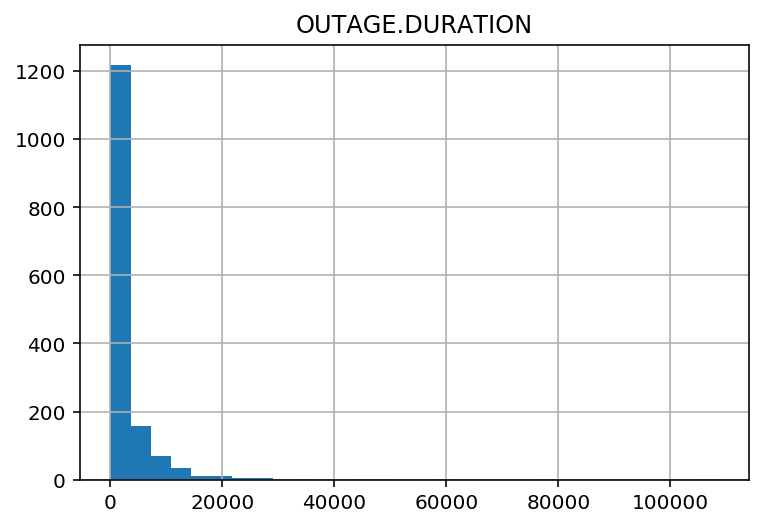

In [99]:
#outliers
subset.hist(column = 'OUTAGE.DURATION', bins = 30)

In [100]:
max(subset['OUTAGE.DURATION'])

108653.0

In [101]:
sum(subset['OUTAGE.DURATION']>20000)

26

It looks like there are only 24 values with outage durations greater than 20000. We are not going to do a formal evaluation of outliers, as for our purposes it is satisfactory to just remove these 24 values. It can be seen in the histogram above that values above 20000 are certainly well above the norm.

In [102]:
subset = subset[(subset['OUTAGE.DURATION'] <= 20000)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D0A3D38780>]],
      dtype=object)

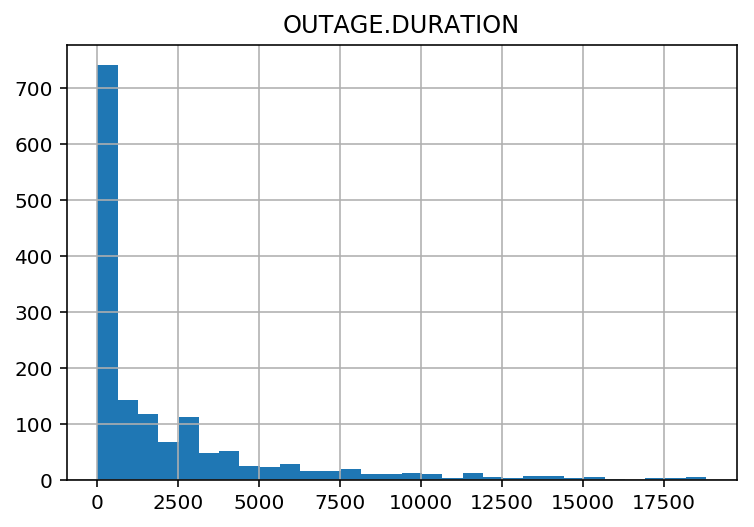

In [103]:
subset.hist(column = 'OUTAGE.DURATION', bins = 30)

The outage duration is still heavily skewed. We might be able to get more accurate results if we apply a log transformation to this variable thereby applying less weight to the very high outage durations.

Let's do a bit of feature engineering. We change month to a string and one hot encode it. Month was being treated as a numeric variable in the baseline model when it should probably be treated as categorical. Next, we apply a log transformation to outage duration. In addition, in predicting the cause of a power outage, it would be helpful to know the temperature anomoly level relative to the climate region, rather than in absolute terms. To do this we apply a standard scaler to the anomoly level within climate region groups. Before this can be done a standard scaler by group function is defined:

In [104]:


class StdScalerByGroup(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)
        
        # A dictionary of means/standard-deviations for each column, for each group.
        
        #use X.columns[0] since groups are always in first column
        agg = df.groupby(X.columns[0]).agg(['mean', 'std'])

        self.grps_ = agg.to_dict()

        return self

    def transform(self, X, y=None):

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("transformer must be fit before transforming data")
        
        def z_helper(series):
            group_name = series.name
            series = series.set_index(series.columns[0])
            def standardize(col):
                mean = self.grps_[(col.name, 'mean')][group_name]
                std = self.grps_[(col.name, 'std')][group_name]
                standardized = (col - mean) / std
                return standardized

            return series.apply(standardize)
            
        
        # X may not be a dataframe (e.g. np.array)

        df = pd.DataFrame(X)
        
        return df.groupby(df.columns[0]).apply(z_helper)
        

Now we can create the pipeline

In [105]:
def to_string(x):
        return pd.DataFrame(x).astype(str)
def log_transform(x):
    return np.log(x + 1)
num_to_str = FunctionTransformer(func = to_string, validate=False)
log_trans = FunctionTransformer(func = log_transform, validate=False)

month_trans = Pipeline(steps = [
            ('to_string', num_to_str),
            #added categories='auto' to silence warning message
            #handle_unknown incase there are unseen values in the test set
            ('ohe', OneHotEncoder(handle_unknown = 'ignore', categories='auto'))
            ])

ct = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore', categories='auto'), ['POSTAL.CODE', 'CLIMATE.REGION']),
        ('std', StdScalerByGroup(), ['CLIMATE.REGION','ANOMALY.LEVEL']),
        ('month_trans', month_trans, ['MONTH']),
        ('log_trans', log_trans, ['OUTAGE.DURATION'])
    ])
pl = Pipeline(steps = [
            ('columntrans', ct),
            ('knn',  KNeighborsClassifier(n_neighbors = best_n))
            ])

Let's check the average accuracy

In [106]:
#finding average average accuracy

accuracies = []
for i in range(400):
    y = subset['CAUSE.CATEGORY']
    x = subset.drop('CAUSE.CATEGORY', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    pl.fit(x_train, y_train)
    accuracies.append(accuracy_score(y_test, pl.predict(x_test)))

In [107]:
pd.Series(accuracies).mean()

0.6718716577540101

it is, in fact, an improvement on the baseline model! 

### Fairness Evaluation

For the fairness evaluation we will see if predictions are equally accurate for high and low income states. We will define the cutoff for a high income state as simply the median real per capita GSP in the dataset. Note that this measure varies over time, meaning that there are more than 50 unique values for this variable. This means that a state could be considered low income in one year and high income in another. 

In [108]:
income_cutoff = subset['PC.REALGSP.STATE'].median()

In [109]:
#create boolean variable
subset['low_income'] = subset['PC.REALGSP.STATE'] < income_cutoff

We can define a function that will give us the average accuracy over 10 train-test-split iterations. 10 is a bit low but this function will be iterated over later so we can't have it take too long.

In [110]:
def get_accuracy(df):
    accuracies = []
    for i in range(10):
        y = subset['CAUSE.CATEGORY']
        x = subset.drop('CAUSE.CATEGORY', axis=1)
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        pl.fit(x_train, y_train)
        accuracies.append(accuracy_score(y_test, pl.predict(x_test)))
    return pd.Series(accuracies).mean()

First let's see what the observed difference in accuracy is between high and low income states

In [111]:
high_income = subset[subset['PC.REALGSP.STATE'] >= income_cutoff]
low_income = subset[subset['PC.REALGSP.STATE'] < income_cutoff]

#calculate observed statistic
#it will be the difference bewteen the stat for the high income and low income

observed_stat = get_accuracy(high_income) - get_accuracy(low_income)

In [112]:
observed_stat

-0.0149732620320856

This is pretty close to 0, but is it significantly different from 0? Let's run a permutation test to answer this question. We will shuffle the PC.REALGSP.STATE variable 100 times and record the differences in accuracy between high and low income states. 

Our null hypothesis will be that accuracy is the same for high and low income states, the alternative hypothesis being that accuracy is different for high and low income states. We will set the significance level as 0.05.

In [115]:
gen_stats = []
for i in range(100):  
    #shuffle column of interest
    shuffled_col = (
        subset['PC.REALGSP.STATE']
        .sample(replace = False, frac=1)
        .reset_index(drop=True)
    )

    #assign shuffled column to original dataframe
    shuffled_df = (
        subset.assign(**{
            'PC.REALGSP.STATE':shuffled_col,
        })
    )
    #calculate statistic
    high_income = shuffled_df[shuffled_df['PC.REALGSP.STATE'] >= income_cutoff]
    low_income = shuffled_df[shuffled_df['PC.REALGSP.STATE'] < income_cutoff]
    
    gen_stats.append(get_accuracy(high_income) - get_accuracy(low_income))

p value = 0.08


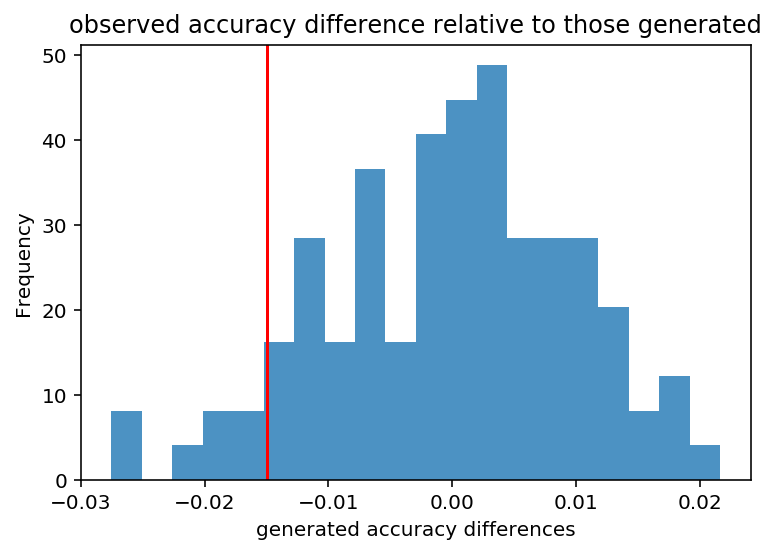

In [116]:
pd.Series(gen_stats).plot(kind='hist', density=True, alpha = 0.8, bins=20)
plt.xlabel("generated accuracy differences")
plt.title("observed accuracy difference relative to those generated")
plt.axvline(x=observed_stat, color='red')

print('p value = ' + str(np.mean(pd.Series(gen_stats) <= observed_stat)))

Since the p-value is greater than our significance level we fail to reject the null hypthesis that accuracy is different for high and low income states. There is not evidence to suggest unfairness for high and low income states. 